In [118]:
import tensorflow as tf
import keras
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import cv2
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
import skimage

In [2]:
from keras import Sequential
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation

In [3]:
from keras.preprocessing.image import ImageDataGenerator

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Preprocessing the data

In [5]:
training_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

In [7]:
train_ds = training_datagen.flow_from_directory('Data',
                                             target_size=(224, 224), batch_size=3681,
                                             class_mode=None, subset="training")

Found 3681 images belonging to 1 classes.


In [9]:
valid_ds = training_datagen.flow_from_directory('Data',
                                             target_size=(224, 224), batch_size=649,
                                             class_mode=None, subset="validation")

Found 649 images belonging to 1 classes.


Below function will take return a matrix $X$ with the $L$ channel from the $Lab$ colorspace representation of the images.
Matrix $Y$ consists of the $a$ and the $b$ channels of the images.

In [10]:
def convert_to_lab(ds):
    X =[]
    Y =[]
    for img in ds[0]:
      try:
          lab = rgb2lab(img)
          X.append(lab[:,:,0])
          Y.append(lab[:,:,1:] / 128)
      except:
         print('error')
    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape(X.shape+(1,))
    print(X.shape)
    print(Y.shape)
    
    return X, Y

In [11]:
X_train, Y = convert_to_lab(train_ds)

(3681, 224, 224, 1)
(3681, 224, 224, 2)


Below function will copy the $L$ channel thrice so that the input is compatible with the requirements of ResNet50 (encoding part of the architecture) 

In [12]:
def prepare_input(X, n):
    X_ = np.zeros([n, 224, 224, 3])
    X_[:, :, :, 0] = X[:, :, :, 0]
    X_[:, :, :, 1] = X[:, :, :, 0]
    X_[:, :, :, 2] = X[:, :, :, 0]
    return X_

In [13]:
X_train = prepare_input(X_train, 3681)

## Building the model

The model is an autoencoder, which takes in the $L$ channel from the Lab space of an image, and tries to estimate its $a$ and $b$ channels.

The encoding part of the architecture is a ResNet50 model, pretrained on the Imagenet dataset. This part of the model is kept untrainable so that the pretrained weights don't get disturbed.

The decoding part of the architecture is a series of Transpose Convolution layers with stride = 2. 

In [17]:
resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=[224, 224, 3])

In [18]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [19]:
decoder = Sequential([
    Conv2DTranspose(1024, kernel_size=3, padding="SAME", strides=2, input_shape=[7, 7, 2048]),
    BatchNormalization(),
    keras.layers.LeakyReLU(0.2),

    Conv2DTranspose(512, kernel_size=3, padding="SAME", strides=2),
    BatchNormalization(),
    keras.layers.LeakyReLU(0.2),
    
    Conv2DTranspose(256, kernel_size=3, padding="SAME", strides=2),
    BatchNormalization(),
    keras.layers.LeakyReLU(0.2),
    
    Conv2DTranspose(128, kernel_size=3, padding="SAME", strides=2),
    BatchNormalization(),
    keras.layers.LeakyReLU(0.2),
    
    Conv2DTranspose(32, kernel_size=3, padding="SAME", strides=2),
    BatchNormalization(),
    keras.layers.LeakyReLU(0.2),

    Conv2DTranspose(2, kernel_size=3, padding="SAME", strides=1, activation='tanh'),
])

In [20]:
decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 14, 14, 1024)      18875392  
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 1024)      4096      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 1024)      0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 512)       4719104   
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 512)       2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 512)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 56, 56, 256)       1

In [21]:
resnet.trainable = False
model = Sequential([resnet, decoder])
model.compile(optimizer='Adam', loss='mse')

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 2)       25114722  
Total params: 48,702,434
Trainable params: 25,110,818
Non-trainable params: 23,591,616
_________________________________________________________________


In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= "loss", patience = 25, restore_best_weights= False, verbose = True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= "loss", factor = 0.5, patience = 15,
                                                 min_lr = 0.000001, verbose = 1)

## Training

In [25]:
model.fit(X_train, Y, epochs=500, batch_size=8, callbacks=[early_stopping, reduce_lr])

Epoch 1/500
461/461 [==============================] - 112s 243ms/step - loss: 0.0206
Epoch 2/500
461/461 [==============================] - 110s 240ms/step - loss: 0.0131
Epoch 3/500
461/461 [==============================] - 110s 240ms/step - loss: 0.0125
Epoch 4/500
461/461 [==============================] - 112s 243ms/step - loss: 0.0122
Epoch 5/500
461/461 [==============================] - 111s 241ms/step - loss: 0.0118
Epoch 6/500
461/461 [==============================] - 111s 240ms/step - loss: 0.0116
Epoch 7/500
461/461 [==============================] - 111s 240ms/step - loss: 0.0114
Epoch 8/500
461/461 [==============================] - 111s 240ms/step - loss: 0.0111
Epoch 9/500
461/461 [==============================] - 111s 240ms/step - loss: 0.0110
Epoch 10/500
461/461 [==============================] - 110s 240ms/step - loss: 0.0107
Epoch 11/500
461/461 [==============================] - 110s 238ms/step - loss: 0.0105
Epoch 12/500
461/461 [==============================

KeyboardInterrupt: 

I ended the training prematurely, thinking it might have overfit 😅. Anyways, it works pretty good.

In [31]:
model.save("colorizer.h5")

## Testing

### First, on an image from the training set

In [348]:
def predict(model, X, i):
    grayscale = X[i, :, :, :]
    grayscale = grayscale[np.newaxis, ...]
    pred_ab_channels = model.predict(grayscale)
    im = np.zeros([224, 224, 3])
    im[:, :, 0] = X[i, :, :, 0]
    im[:, :, 1] = pred_ab_channels[0, :, :, 0]*128
    im[:, :, 2] = pred_ab_channels[0, :, :, 1]*128
    image = lab2rgb(im)
    image = cv2.resize(image, (224, 224))
    plt.imshow(image)
    return image

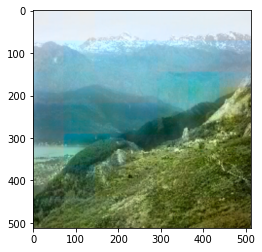

In [84]:
predict(model, X_train, 12)

### Now, on an image from the validation set

In [345]:
X_valid,y_valid = convert_to_lab(valid_ds)

(100, 224, 224, 1)
(100, 224, 224, 2)


In [346]:
X_valid = add_channels(X_valid, 100)

#### Predicted image

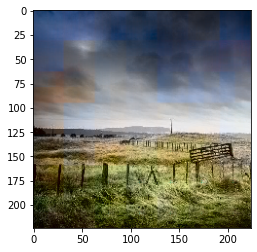

In [458]:
image = predict(model, X_valid, 43)
image = image.astype('float32')

In [459]:
cv2.imwrite("save/colorized16.jpg", cv2.cvtColor(image*255, cv2.COLOR_RGB2BGR))

True

#### Gray scale image

True

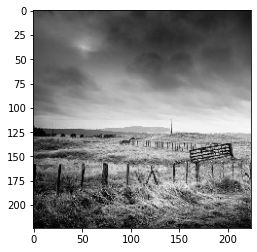

In [460]:
image = cv2.resize(rgb2gray(X_valid[43]/255), (224, 224))
plt.imshow(image, cmap='gray')
cv2.imwrite("save/grayscale16.jpg", image*255)

#### Ground Truth

True

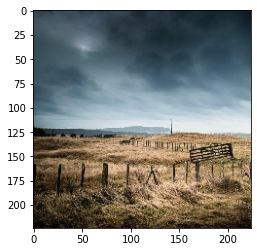

In [461]:
true = np.zeros([224, 224, 3])
true[:, :, 0] = X_valid[43][:, :, 0]
true[:, :, 1] = y_valid[43][:, :, 0]*128
true[:, :, 2] = y_valid[43][:, :, 1]*128
plt.imshow(lab2rgb(true))
true = lab2rgb(true)
true = true.astype('float32')
cv2.imwrite("save/ground_truth16.jpg", cv2.cvtColor(true*255, cv2.COLOR_RGB2BGR))